In [ ]:
%pip install kaggle


In [ ]:
%mkdir ~/.kaggle


In [ ]:
%cp kaggle.json ~/.kaggle/


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
! kaggle datasets download awsaf49/brats20-dataset-training-validation


Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
100% 4.16G/4.16G [00:59<00:00, 127MB/s]
100% 4.16G/4.16G [00:59<00:00, 74.8MB/s]


In [ ]:
! unzip brats20-dataset-training-validation.zip


In [ ]:
%pip install tensorflow


In [ ]:
%pip install keras


In [ ]:
import os
import cv2
import random
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps
import nibabel as nib
import keras
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
from tensorflow.python.keras.layers import Dense

# Import Keras backend from TensorFlow
import tensorflow.keras.backend as K

# Import callbacks from TensorFlow Keras
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

# Import utilities and layers from TensorFlow Keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import Normalization, Rescaling


In [ ]:
TRAIN_DATASET_PATH = "/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"

In [ ]:
old_name = TRAIN_DATASET_PATH + "BraTS20_Training_355/W39_1998.09.19_Segm.nii"
new_name = TRAIN_DATASET_PATH + "BraTS20_Training_355/BraTS20_Training_355_seg.nii"

print(old_name)

print(os.path.exists(old_name))


# renaming the file
try:
    if os.path.exists(old_name):
        os.rename(old_name, new_name)
        print("File renamed successfully!")
    elif os.path.exists(new_name):
        print("File is already renamed!")
    else:
        print("Original file does not exist.")
except FileNotFoundError:
    print("Error: File not found!")
except FileExistsError:
    print("Error: File already renamed or destination file exists!")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
except:
    print("File is already renamed!")

/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/W39_1998.09.19_Segm.nii
True
File renamed successfully!


In [ ]:
# load .nii file as a numpy array
test_image_flair = nib.load(TRAIN_DATASET_PATH + "BraTS20_Training_355/BraTS20_Training_355_flair.nii").get_fdata()
print("Shape: ", test_image_flair.shape)
print("Dtype: ", test_image_flair.dtype)

Shape:  (240, 240, 155)
Dtype:  float64


In [ ]:
print("Min: ", test_image_flair.min())
print("Max: ", test_image_flair.max())

Min:  0.0
Max:  1854.603271484375


In [ ]:
scaler = MinMaxScaler()


In [ ]:
# Scale the test_image_flair array and then reshape it back to its original dimensions.
# This ensures the data is normalized/standardized for model input without altering its spatial structure.
test_image_flair = scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

In [ ]:
print("Min: ", test_image_flair.min())
print("Max: ", test_image_flair.max())

Min:  0.0
Max:  1.0


In [ ]:
# rescaling t1
test_image_t1 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()
test_image_t1 = scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

# rescaling t1ce
test_image_t1ce = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
test_image_t1ce = scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

# rescaling t2
test_image_t2 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
test_image_t2 = scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)
# we will not rescale the mask
test_image_seg = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_seg.nii').get_fdata()

Slice Number: 95


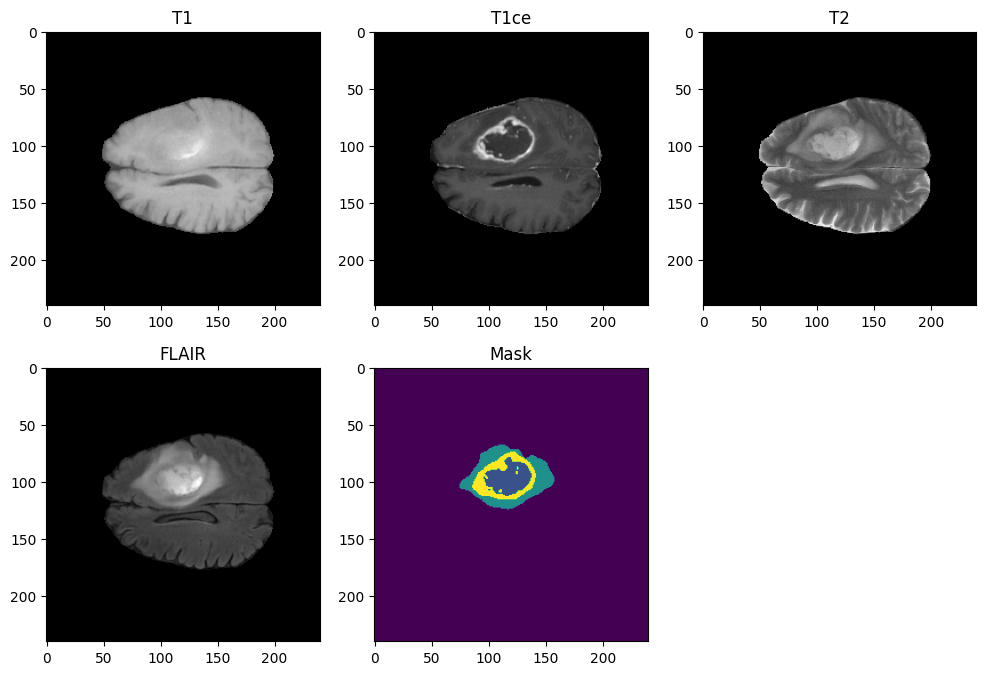

In [ ]:
slice = 95

print("Slice Number: " + str(slice))

plt.figure(figsize=(12, 8))

# T1
plt.subplot(2, 3, 1)
plt.imshow(test_image_t1[:,:,slice], cmap='gray')
plt.title('T1')

# T1ce
plt.subplot(2, 3, 2)
plt.imshow(test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1ce')
# T2
plt.subplot(2, 3, 3)
plt.imshow(test_image_t2[:,:,slice], cmap='gray')
plt.title('T2')

# Flair
plt.subplot(2, 3, 4)
plt.imshow(test_image_flair[:,:,slice], cmap='gray')
plt.title('FLAIR')

# Mask
plt.subplot(2, 3, 5)
plt.imshow(test_image_seg[:,:,slice])
plt.title('Mask')
plt.show()

In [ ]:
# Modality shape
print("Modality: ", test_image_t1.shape)

# Segmentation shape
print("Segmentation: ", test_image_seg.shape)

Modality:  (240, 240, 155)
Segmentation:  (240, 240, 155)


Slice number: 95


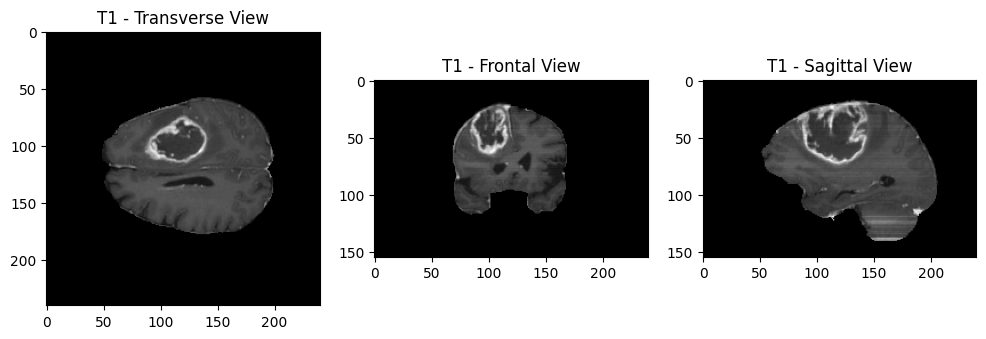

In [ ]:
slice = 95

print("Slice number: " + str(slice))

plt.figure(figsize=(12, 8))

# Apply a 90° rotation with an automatic resizing, otherwise the display is less obvious to analyze
# T1 - Transverse View
plt.subplot(1, 3, 1)
plt.imshow(test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1 - Transverse View')

# T1 - Frontal View
plt.subplot(1, 3, 2)
plt.imshow(rotate(test_image_t1ce[:,slice,:], 90, resize=True), cmap='gray')
plt.title('T1 - Frontal View')

# T1 - Sagittal View
plt.subplot(1, 3, 3)
plt.imshow(rotate(test_image_t1ce[slice,:,:], 90, resize=True), cmap='gray')
plt.title('T1 - Sagittal View')
plt.show()

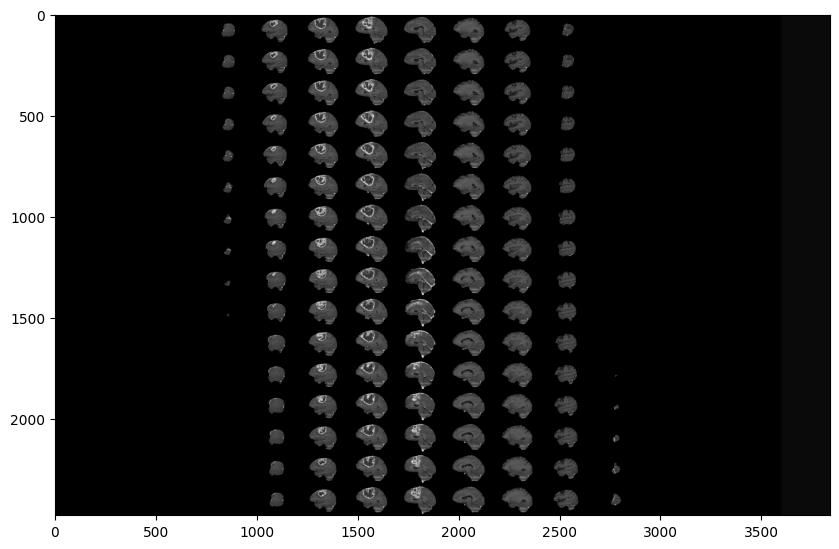

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)

# montage allows us to concatenate multiple images of the same size horizontally and vertically
plt.imshow(rotate(montage(test_image_t1ce[:,:,:]), 90, resize=True), cmap ='gray');

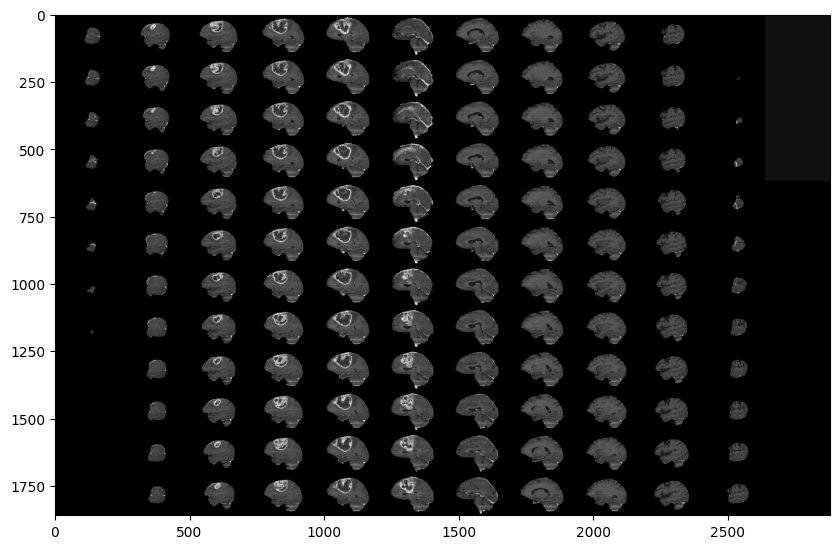

In [ ]:
# Skip 50:-50 slices since there is not much to see
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
plt.imshow(rotate(montage(test_image_t1ce[50:-50,:,:]), 90, resize=True), cmap ='gray');

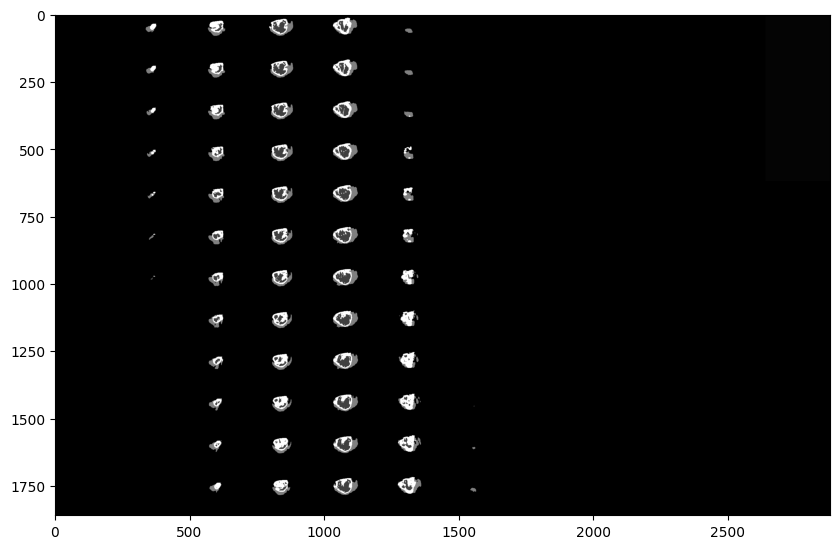

In [ ]:
# Skip 50:-50 slices since there is not much to see
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
plt.imshow(rotate(montage(test_image_seg[50:-50,:,:]), 90, resize=True), cmap ='gray');

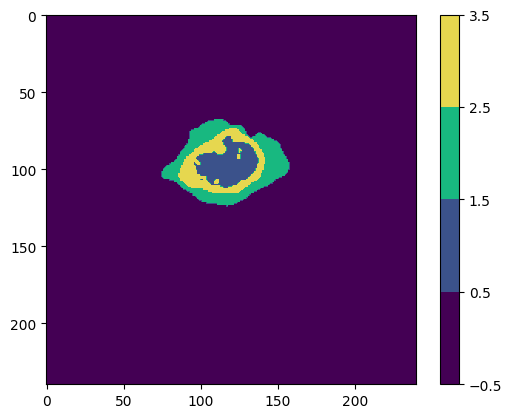

In [ ]:
# Plotting the segmantation
cmap = matplotlib.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = matplotlib.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

# plotting the 95th slice
plt.imshow(test_image_seg[:,:,95], cmap=cmap, norm=norm)
plt.colorbar()
plt.show()

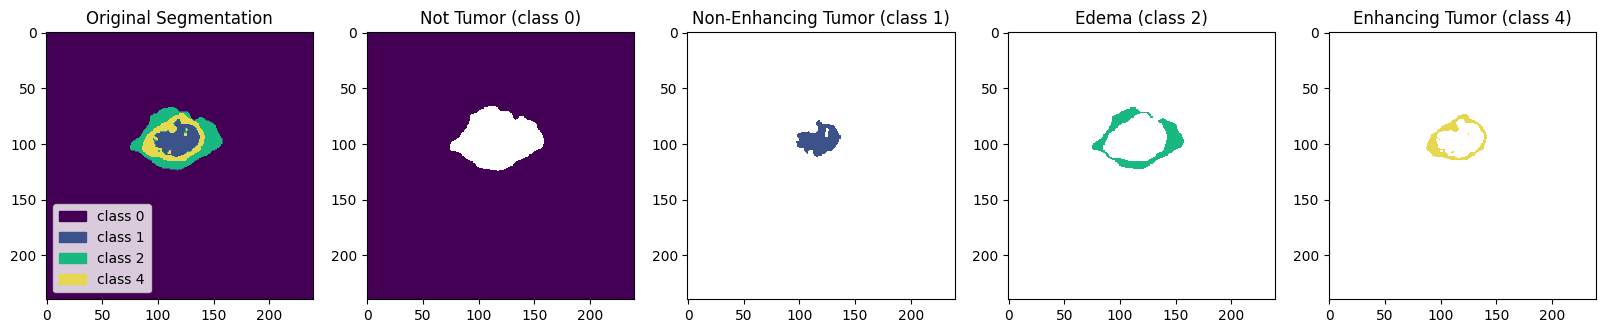

In [ ]:
# Isolation of class 0
seg_0 = test_image_seg.copy()
seg_0[seg_0 != 0] = np.nan

# Isolation of class 1
seg_1 = test_image_seg.copy()
seg_1[seg_1 != 1] = np.nan

# Isolation of class 2
seg_2 = test_image_seg.copy()
seg_2[seg_2 != 2] = np.nan

# Isolation of class 4
seg_4 = test_image_seg.copy()
seg_4[seg_4 != 4] = np.nan

# Define legend
class_names = ['class 0', 'class 1', 'class 2', 'class 4']
legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

fig, ax = plt.subplots(1, 5, figsize=(20, 20))

ax[0].imshow(test_image_seg[:,:, slice], cmap=cmap, norm=norm)
ax[0].set_title('Original Segmentation')
ax[0].legend(handles=legend, loc='lower left')

ax[1].imshow(seg_0[:,:, slice], cmap=cmap, norm=norm)
ax[1].set_title('Not Tumor (class 0)')

ax[2].imshow(seg_1[:,:, slice], cmap=cmap, norm=norm)
ax[2].set_title('Non-Enhancing Tumor (class 1)')

ax[3].imshow(seg_2[:,:, slice], cmap=cmap, norm=norm)
ax[3].set_title('Edema (class 2)')
ax[4].imshow(seg_4[:,:, slice], cmap=cmap, norm=norm)
ax[4].set_title('Enhancing Tumor (class 4)')

plt.show()

In [ ]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);

train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

In [ ]:
# Print data distribution (Train: 68%, Test: 12%, Val: 20%)
print(f"Train length: {len(train_ids)}")
print(f"Validation length: {len(val_ids)}")
print(f"Test length: {len(test_ids)}")

Train length: 250
Validation length: 74
Test length: 45


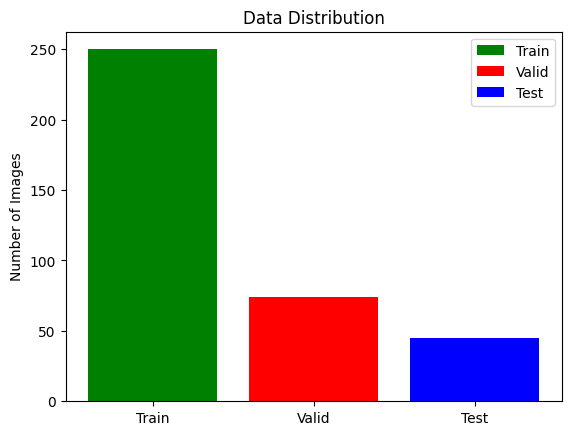

In [ ]:
plt.bar(["Train","Valid","Test"],
        [len(train_ids), len(val_ids), len(test_ids)],
        align='center',
        color=[ 'green','red', 'blue'],
        label=["Train", "Valid", "Test"]
       )

plt.legend()

plt.ylabel('Number of Images')
plt.title('Data Distribution')

plt.show()


In [ ]:
# Define seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3
}

# Select Slices and Image Size
VOLUME_SLICES = 100
VOLUME_START_AT = 22 # first slice of volume that we will include
IMG_SIZE=128

In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))


        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            t1ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];

        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y

training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)


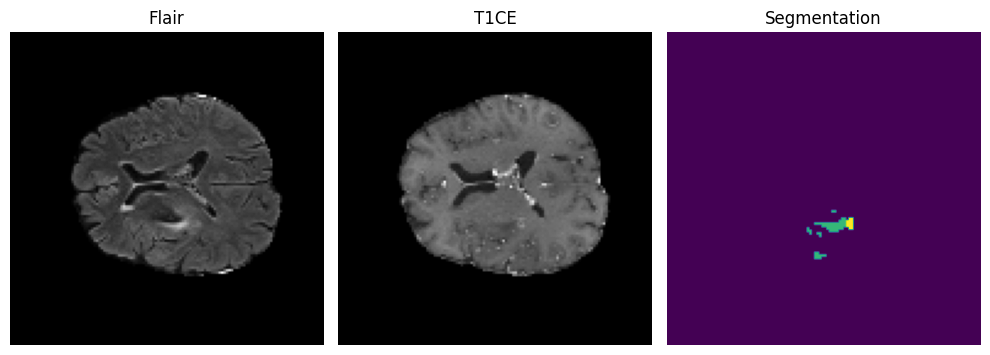

In [ ]:
# Define a function to display one slice and its segmentation
def display_slice_and_segmentation(flair, t1ce, segmentation):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    axes[0].imshow(flair, cmap='gray')
    axes[0].set_title('Flair')
    axes[0].axis('off')

    axes[1].imshow(t1ce, cmap='gray')
    axes[1].set_title('T1CE')
    axes[1].axis('off')

    axes[2].imshow(segmentation) # Displaying segmentation
    axes[2].set_title('Segmentation')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# Retrieve the batch from the training generator
X_batch, Y_batch = training_generator[8]

# Extract Flair, T1CE, and segmentation from the batch
flair_batch = X_batch[:, :, :, 0]
t1ce_batch = X_batch[:, :, :, 1]
segmentation_batch = np.argmax(Y_batch, axis=-1)  # Convert one-hot encoded to categorical

# Extract the 50th slice from Flair, T1CE, and segmentation
slice_index = 60  # Indexing starts from 0
slice_flair = flair_batch[slice_index]
slice_t1ce = t1ce_batch[slice_index]
slice_segmentation = segmentation_batch[slice_index]

# Display the 50th slice and its segmentation
display_slice_and_segmentation(slice_flair, slice_t1ce, slice_segmentation)

In [ ]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

In [ ]:
# Define per class evaluation of dice coef
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)

In [ ]:
# Computing Precision
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision


# Computing Sensitivity
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)


    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)

    return Model(inputs = inputs, outputs = conv10)

In [ ]:
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing])

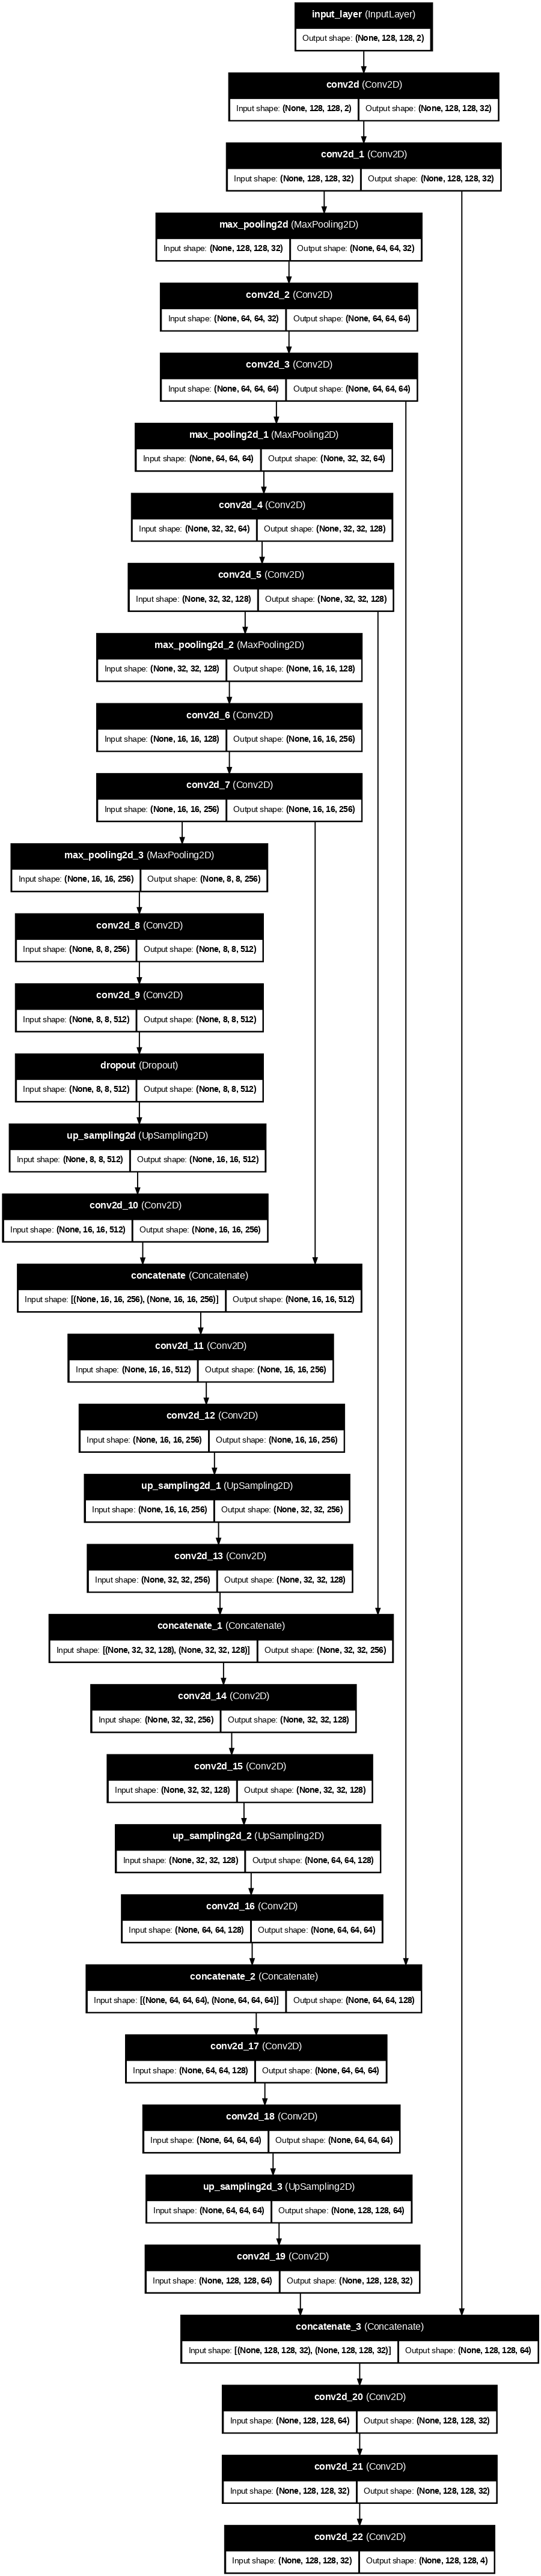

In [ ]:
plot_model(model,
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True,
           rankdir = 'TB',
           expand_nested = False,
           dpi = 70)

In [ ]:
callbacks = [
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                            patience=2, min_lr=0.000001, verbose=1),
      keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.weights.h5',
                          verbose=1, save_best_only=True, save_weights_only = True),
      CSVLogger('training.log', separator=',', append=False)
    ]

In [ ]:
history =  model.fit(training_generator,
                    epochs=35,
                    steps_per_epoch=len(train_ids),
                    callbacks= callbacks,
                    validation_data = valid_generator
                    )

Epoch 1/35


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.9770 - dice_coef: 0.2521 - dice_coef_edema: 0.0962 - dice_coef_enhancing: 0.0335 - dice_coef_necrotic: 0.0328 - loss: 0.3047 - mean_io_u: 0.4789 - precision: 0.9491 - sensitivity: 0.9136 - specificity: 0.9946
Epoch 1: val_loss improved from inf to 0.09224, saving model to model_.01-0.092243.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 285s 854ms/step - accuracy: 0.9770 - dice_coef: 0.2522 - dice_coef_edema: 0.0963 - dice_coef_enhancing: 0.0335 - dice_coef_necrotic: 0.0329 - loss: 0.3040 - mean_io_u: 0.4789 - precision: 0.9492 - sensitivity: 0.9138 - specificity: 0.9946 - val_accuracy: 0.9823 - val_dice_coef: 0.2611 - val_dice_coef_edema: 0.0740 - val_dice_coef_enhancing: 0.0067 - val_dice_coef_necrotic: 0.0161 - val_loss: 0.0922 - val_mean_io_u: 0.5000 - val_precision: 0.9822 - val_sensitivity: 0.9823 - val_specificity: 0.9941 - learning_rate: 0.0010
Epoch 2/35


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 0.09224
250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 97ms/step - accuracy: 0.0000e+00 - dice_coef: 0.0000e+00 - dice_coef_edema: 0.0000e+00 - dice_coef_enhancing: 0.0000e+00 - dice_coef_necrotic: 0.0000e+00 - loss: 0.0000e+00 - mean_io_u: 0.0000e+00 - precision: 0.0000e+00 - sensitivity: 0.0000e+00 - specificity: 0.0000e+00 - val_accuracy: 0.9823 - val_dice_coef: 0.2611 - val_dice_coef_edema: 0.0740 - val_dice_coef_enhancing: 0.0067 - val_dice_coef_necrotic: 0.0161 - val_loss: 0.0922 - val_mean_io_u: 0.5000 - val_precision: 0.9822 - val_sensitivity: 0.9823 - val_specificity: 0.9941 - learning_rate: 0.0010
Epoch 3/35
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.9832 - dice_coef: 0.2783 - dice_coef_edema: 0.1596 - dice_coef_enhancing: 0.0620 - dice_coef_necrotic: 0.0713 - loss: 0.0751 - mean_io_u: 0.5066 - precision: 0.9836 - sensitivity: 0.9806 - specificity: 0.9945
Epoch 3: val_loss improved from 0.09224 to 0.06899, saving model to model_.03-0.06

In [ ]:
model.save("my_model.keras")


In [ ]:
model = keras.models.load_model('/content/my_model.keras',
                                   custom_objects={"accuracy" : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef" : dice_coef,
                                                   "precision" : precision,
                                                   "sensitivity" :sensitivity,
                                                   "specificity" :specificity,
                                                   "dice_coef_necrotic" : dice_coef_necrotic,
                                                   "dice_coef_edema" : dice_coef_edema,
                                                    "dice_coef_enhancing" : dice_coef_enhancing
                                                  }, compile=False)

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = Model(model.inputs, last_conv_layer.output)

    classifier_input = Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = Model(classifier_input, x)

    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)

        preds = classifier_model(last_conv_layer_output)
        pooled_preds = tf.reduce_mean(preds, axis=[1, 2])  # Reduce height & width

        top_pred_index = tf.argmax(pooled_preds[0])  # Extract the top predicted class index
        top_pred_index = tf.cast(top_pred_index, tf.int32)  # Ensure it's an integer
        top_class_channel = pooled_preds[0, top_pred_index]  # Directly access the value at the top predicted index

    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(last_conv_layer_output, axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [ ]:
def create_superimposed_visualization(img, heatmap, alpha=0.4):
    # Resize the heatmap to match the image dimensions
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Ensure the heatmap is in the range [0, 255]
    heatmap = np.uint8(255 * heatmap)

    # Apply the color map to the heatmap
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Convert the grayscale image to RGB
    img_rgb = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_GRAY2BGR)

    # Blend the heatmap with the original image using alpha blending
    superimposed_img = cv2.addWeighted(img_rgb, 1 - alpha, heatmap, alpha, 0)

    # Clip values to ensure they stay within the valid range [0, 255]
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

    return superimposed_img


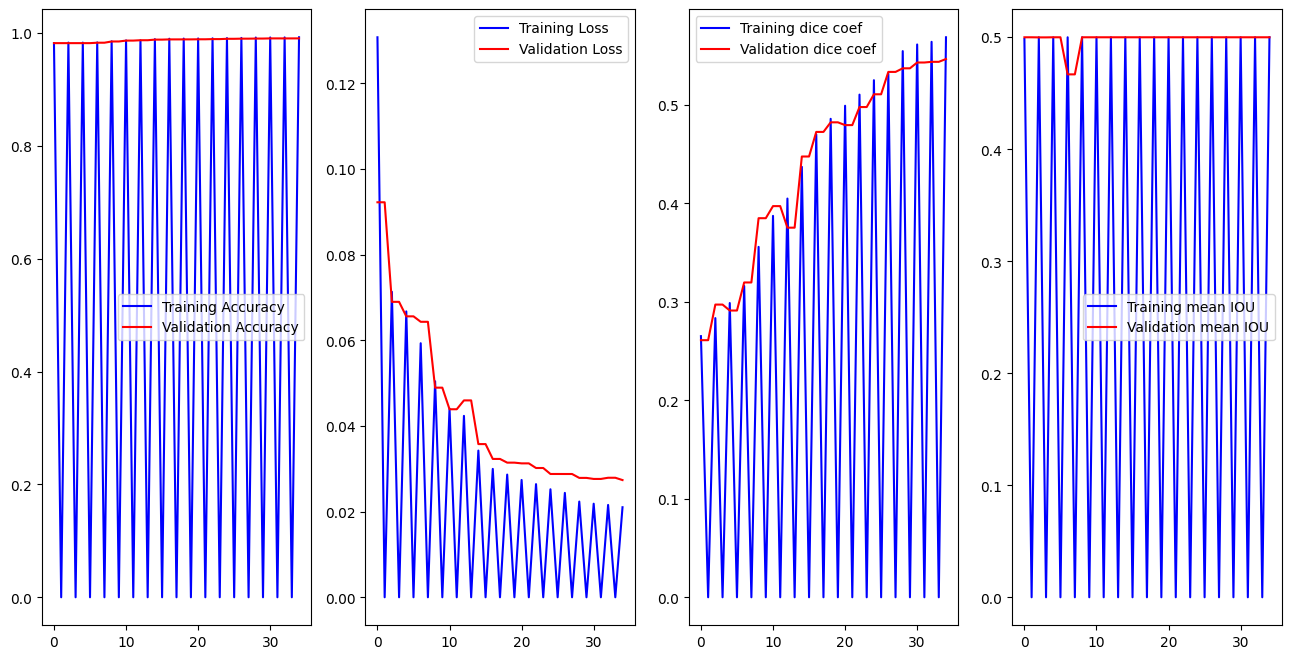

In [ ]:
history = pd.read_csv('/content/training.log', sep=',', engine='python')

hist=history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training mean IOU')

ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

In [ ]:

# Compile a model and load our saved weights
IMG_SIZE = 128
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

best_saved_model = build_unet(input_layer, 'he_normal', 0.2)

best_saved_model.compile(loss="categorical_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing])

best_saved_model.load_weights('/content/model_.35-0.027371.weights.h5')

In [ ]:
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)

In [ ]:
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] )
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')

In [ ]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata()


    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    return model.predict(X/np.max(X), verbose=1)

In [ ]:
print(best_saved_model.summary())


Model: "functional_209"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_110           │ (None, 128, 128, 2)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_115 (Conv2D)       │ (None, 128, 128, 32)   │            608 │ input_layer_110[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_116 (Conv2D)       │ (None, 128, 128, 32)   │          9,248 │ conv2d_115[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_20          │ (None, 64, 64, 32)     │              0 │ conv2d_116[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_117 (Conv2D)       │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_20[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_118 (Conv2D)       │ (None, 64, 64, 64)     │         36,928 │ conv2d_117[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_21          │ (None, 32, 32, 64)     │              0 │ conv2d_118[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_119 (Conv2D)       │ (None, 32, 32, 128)    │         73,856 │ max_pooling2d_21[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_120 (Conv2D)       │ (None, 32, 32, 128)    │        147,584 │ conv2d_119[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_22          │ (None, 16, 16, 128)    │              0 │ conv2d_120[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_121 (Conv2D)       │ (None, 16, 16, 256)    │        295,168 │ max_pooling2d_22[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_122 (Conv2D)       │ (None, 16, 16, 256)    │        590,080 │ conv2d_121[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_23          │ (None, 8, 8, 256)      │              0 │ conv2d_122[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_123 (Conv2D)       │ (None, 8, 8, 512)      │      1,180,160 │ max_pooling2d_23[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_124 (Conv2D)       │ (None, 8, 8, 512)      │      2,359,808 │ conv2d_123[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 8, 8, 512)      │              0 │ conv2d_124[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_20          │ (None, 16, 16, 512)    │              0 │ dropout_5[0][0]        │
│ (UpSampling2D)       

 Total params: 7,759,908 (29.60 MB)

 Trainable params: 7,759,908 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
def showPredictsById(case, start_slice=60):
    path = f"/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path, case)

    core = p[:, :, :, 1]
    edema = p[:, :, :, 2]
    enhancing = p[:, :, :, 3]

    # Prepare the input image for Grad-CAM
    orig_slice = origImage[:, :, start_slice]
    orig_slice_resized = cv2.resize(orig_slice, (IMG_SIZE, IMG_SIZE))

    # Ensure input has 2 channels
    input_img = np.stack((orig_slice_resized, orig_slice_resized), axis=-1)  # Duplicate the channel to create shape (128, 128, 2)
    input_img = np.expand_dims(input_img, axis=0)  # Add batch dimension, final shape: (1, 128, 128, 2)

    # Generate Grad-CAM for each class
    classifier_layer_names = ['conv2d_137']  # Replace with your classifier layers
    gradcam_core = make_gradcam_heatmap(
    input_img,
    best_saved_model,
    last_conv_layer_name='conv2d_135',
    classifier_layer_names=classifier_layer_names
    )

    gradcam_edema = make_gradcam_heatmap(
    input_img,
    best_saved_model,
    last_conv_layer_name='conv2d_135',
    classifier_layer_names=classifier_layer_names
    )

    gradcam_enhancing = make_gradcam_heatmap(
    input_img,
    best_saved_model,
    last_conv_layer_name='conv2d_135',
    classifier_layer_names=classifier_layer_names
    )

    # Create superimposed visualizations
    superimposed_core = create_superimposed_visualization(orig_slice_resized, gradcam_core)
    superimposed_edema = create_superimposed_visualization(orig_slice_resized, gradcam_edema)
    superimposed_enhancing = create_superimposed_visualization(orig_slice_resized, gradcam_enhancing)

    # Visualize original images, predictions, and Grad-CAMs
    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(3, 6, figsize=(18, 15))  # 2 rows for additional Grad-CAMs

    # Row 1: Original visualizations
    for i in range(6):
        axarr[0, i].imshow(cv2.resize(origImage[:, :, start_slice], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')

    axarr[0, 0].imshow(orig_slice_resized, cmap="gray")
    axarr[0, 0].title.set_text('Original image flair')
    curr_gt = cv2.resize(gt[:, :, start_slice], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    axarr[0, 1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3)
    axarr[0, 1].title.set_text('Ground truth')
    axarr[0, 2].imshow(p[start_slice, :, :, 1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[0, 2].title.set_text('All classes predicted')
    axarr[0, 3].imshow(edema[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[0, 3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[0, 4].imshow(core[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[0, 4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[0, 5].imshow(enhancing[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[0, 5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')

    # Row 2: Grad-CAM visualizations
    axarr[1, 0].imshow(gradcam_core)
    axarr[1, 0].title.set_text(f'Grad-CAM: {SEGMENT_CLASSES[1]}')
    axarr[1, 1].imshow(gradcam_edema)
    axarr[1, 1].title.set_text(f'Grad-CAM: {SEGMENT_CLASSES[2]}')
    axarr[1, 2].imshow(gradcam_enhancing)
    axarr[1, 2].title.set_text(f'Grad-CAM: {SEGMENT_CLASSES[3]}')
    for i in range(3, 6):  # Leave the last three columns empty
        axarr[1, i].axis('off')


    # Row 3: Super Imposed visualizations
    axarr[2, 0].imshow(superimposed_core)
    axarr[2, 0].title.set_text(f'Super Imposed: {SEGMENT_CLASSES[1]}')
    axarr[2, 1].imshow(superimposed_edema)
    axarr[2, 1].title.set_text(f'Super Imposed: {SEGMENT_CLASSES[2]}')
    axarr[2, 2].imshow(superimposed_enhancing)
    axarr[2, 2].title.set_text(f'Super Imposed: {SEGMENT_CLASSES[3]}')
    for i in range(3, 6):  # Leave the last three columns empty
        axarr[2, i].axis('off')

    plt.tight_layout()
    plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


<Figure size 1800x5000 with 0 Axes>

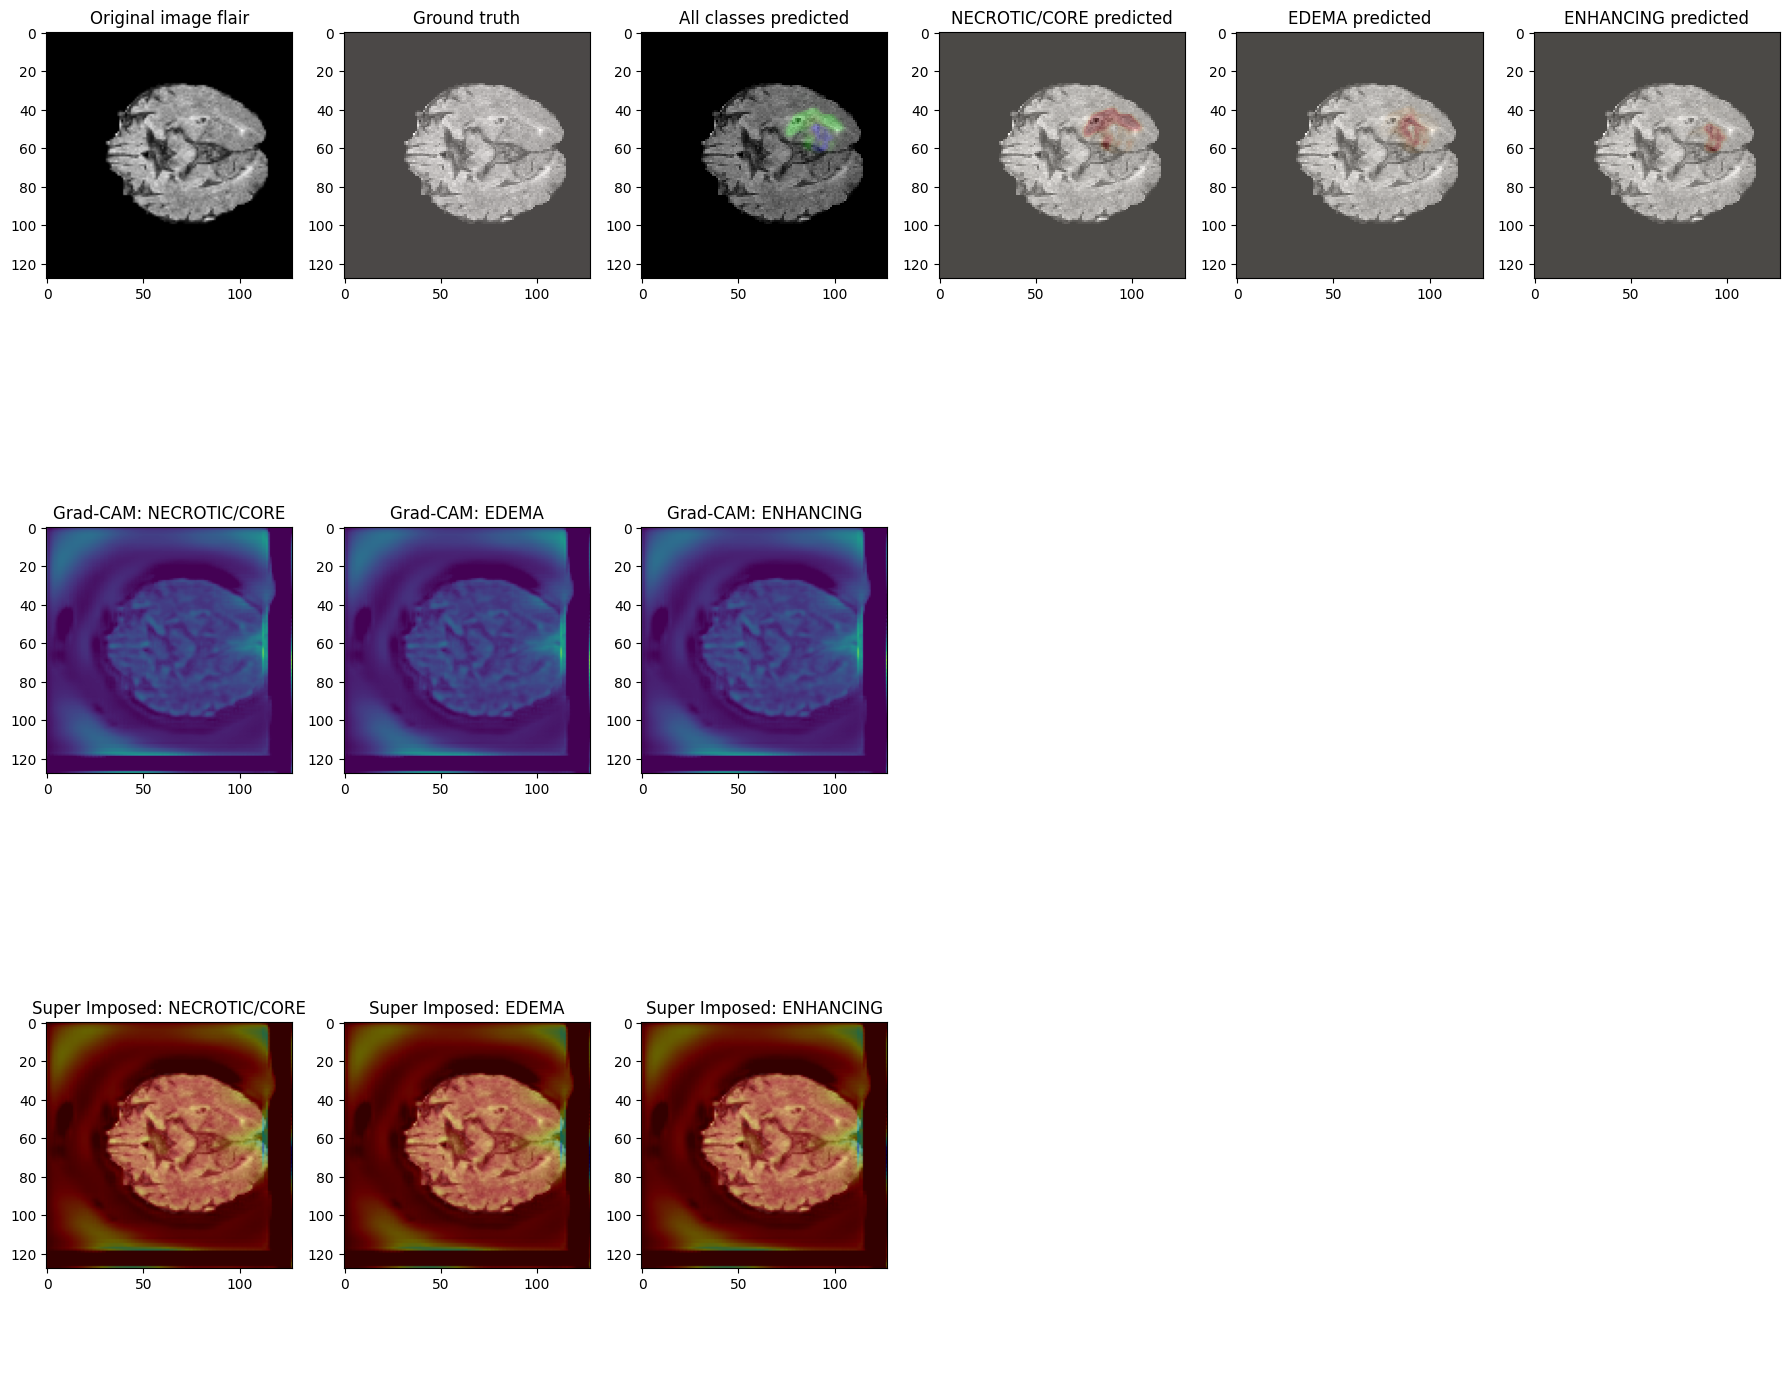

In [ ]:
showPredictsById(case=test_ids[0][-3:])


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


<Figure size 1800x5000 with 0 Axes>

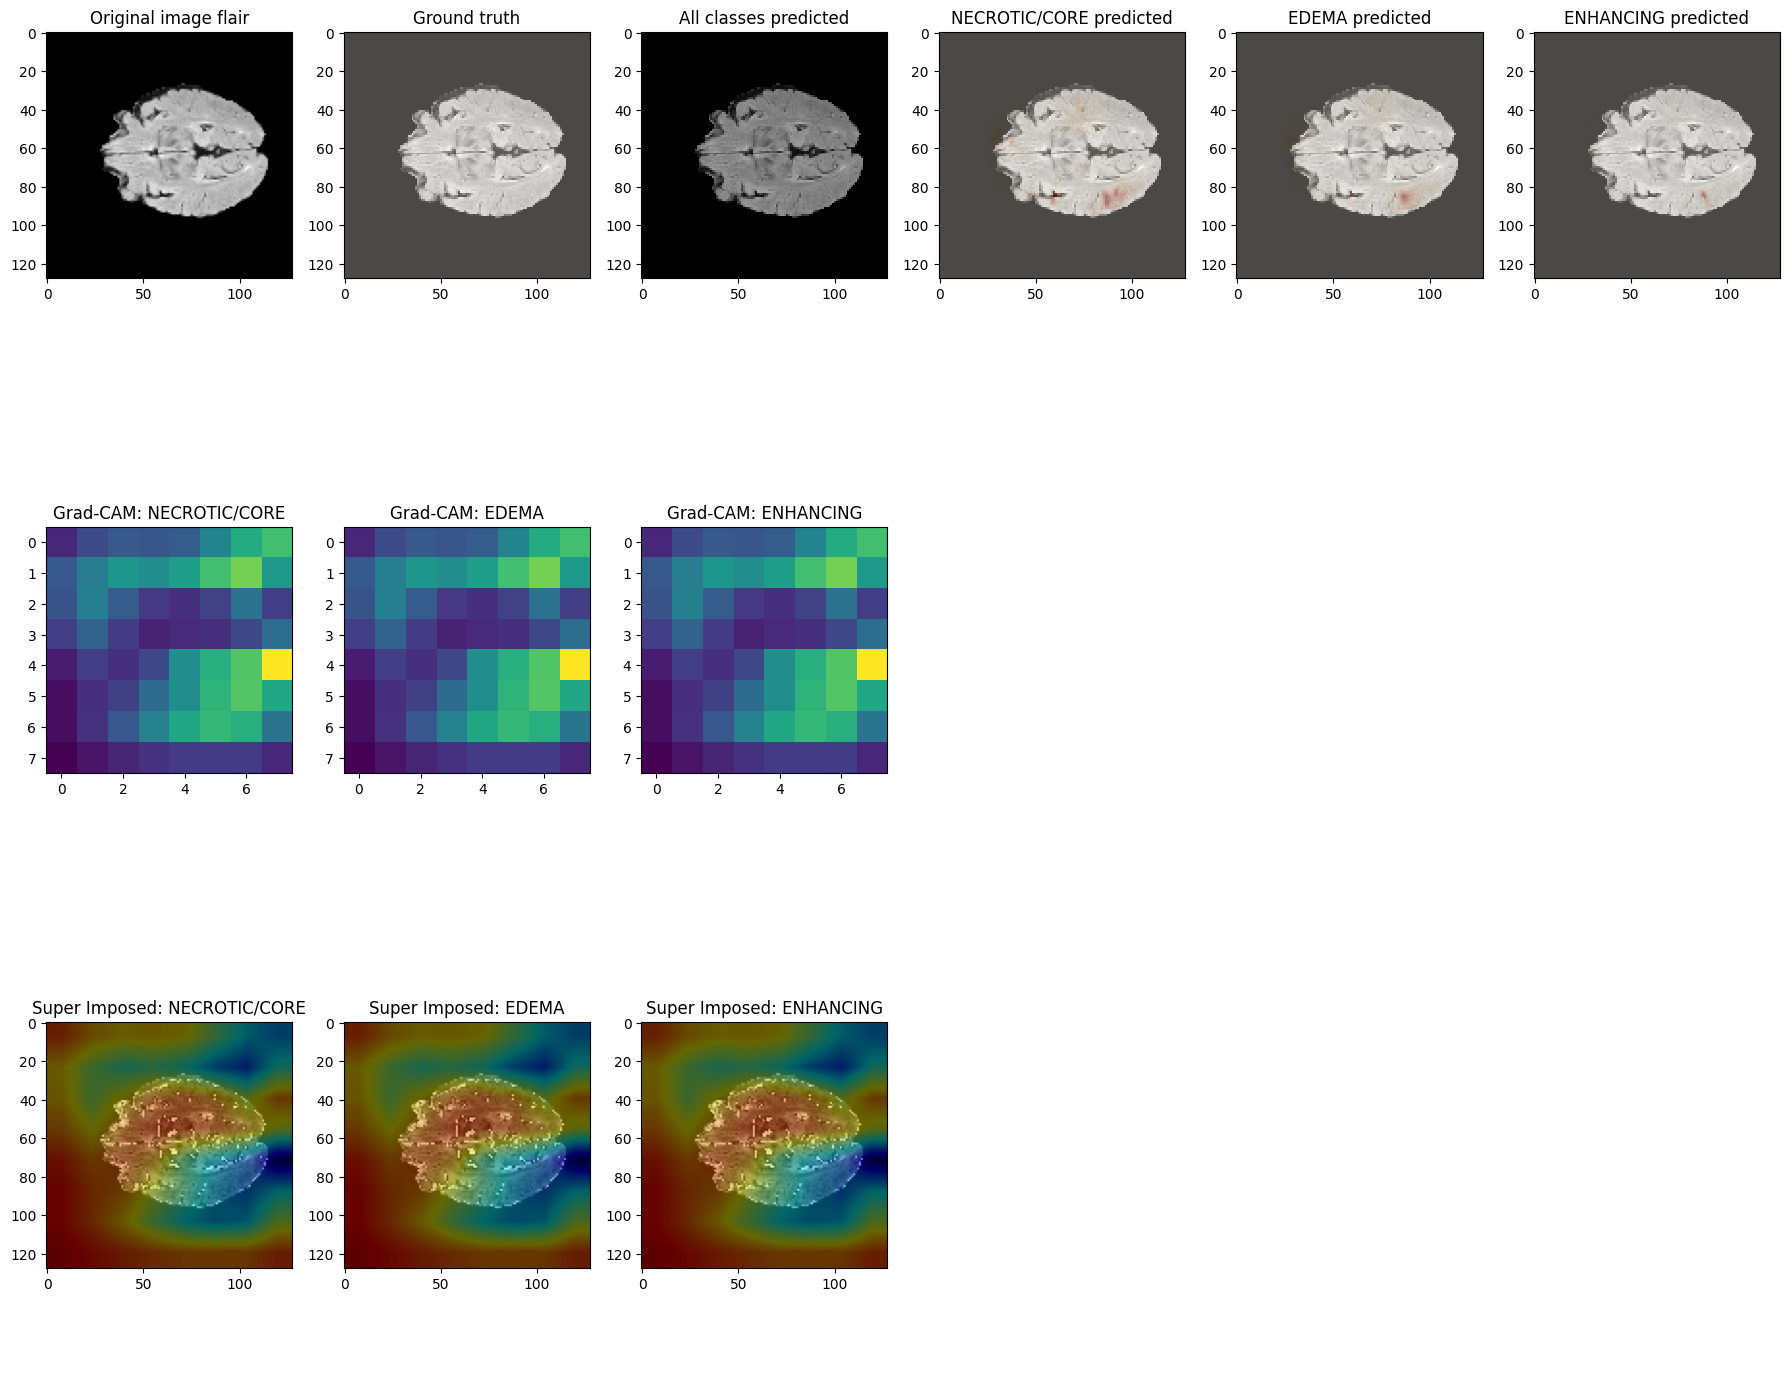

In [ ]:
showPredictsById(case=test_ids[1][-3:])


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


<Figure size 1800x5000 with 0 Axes>

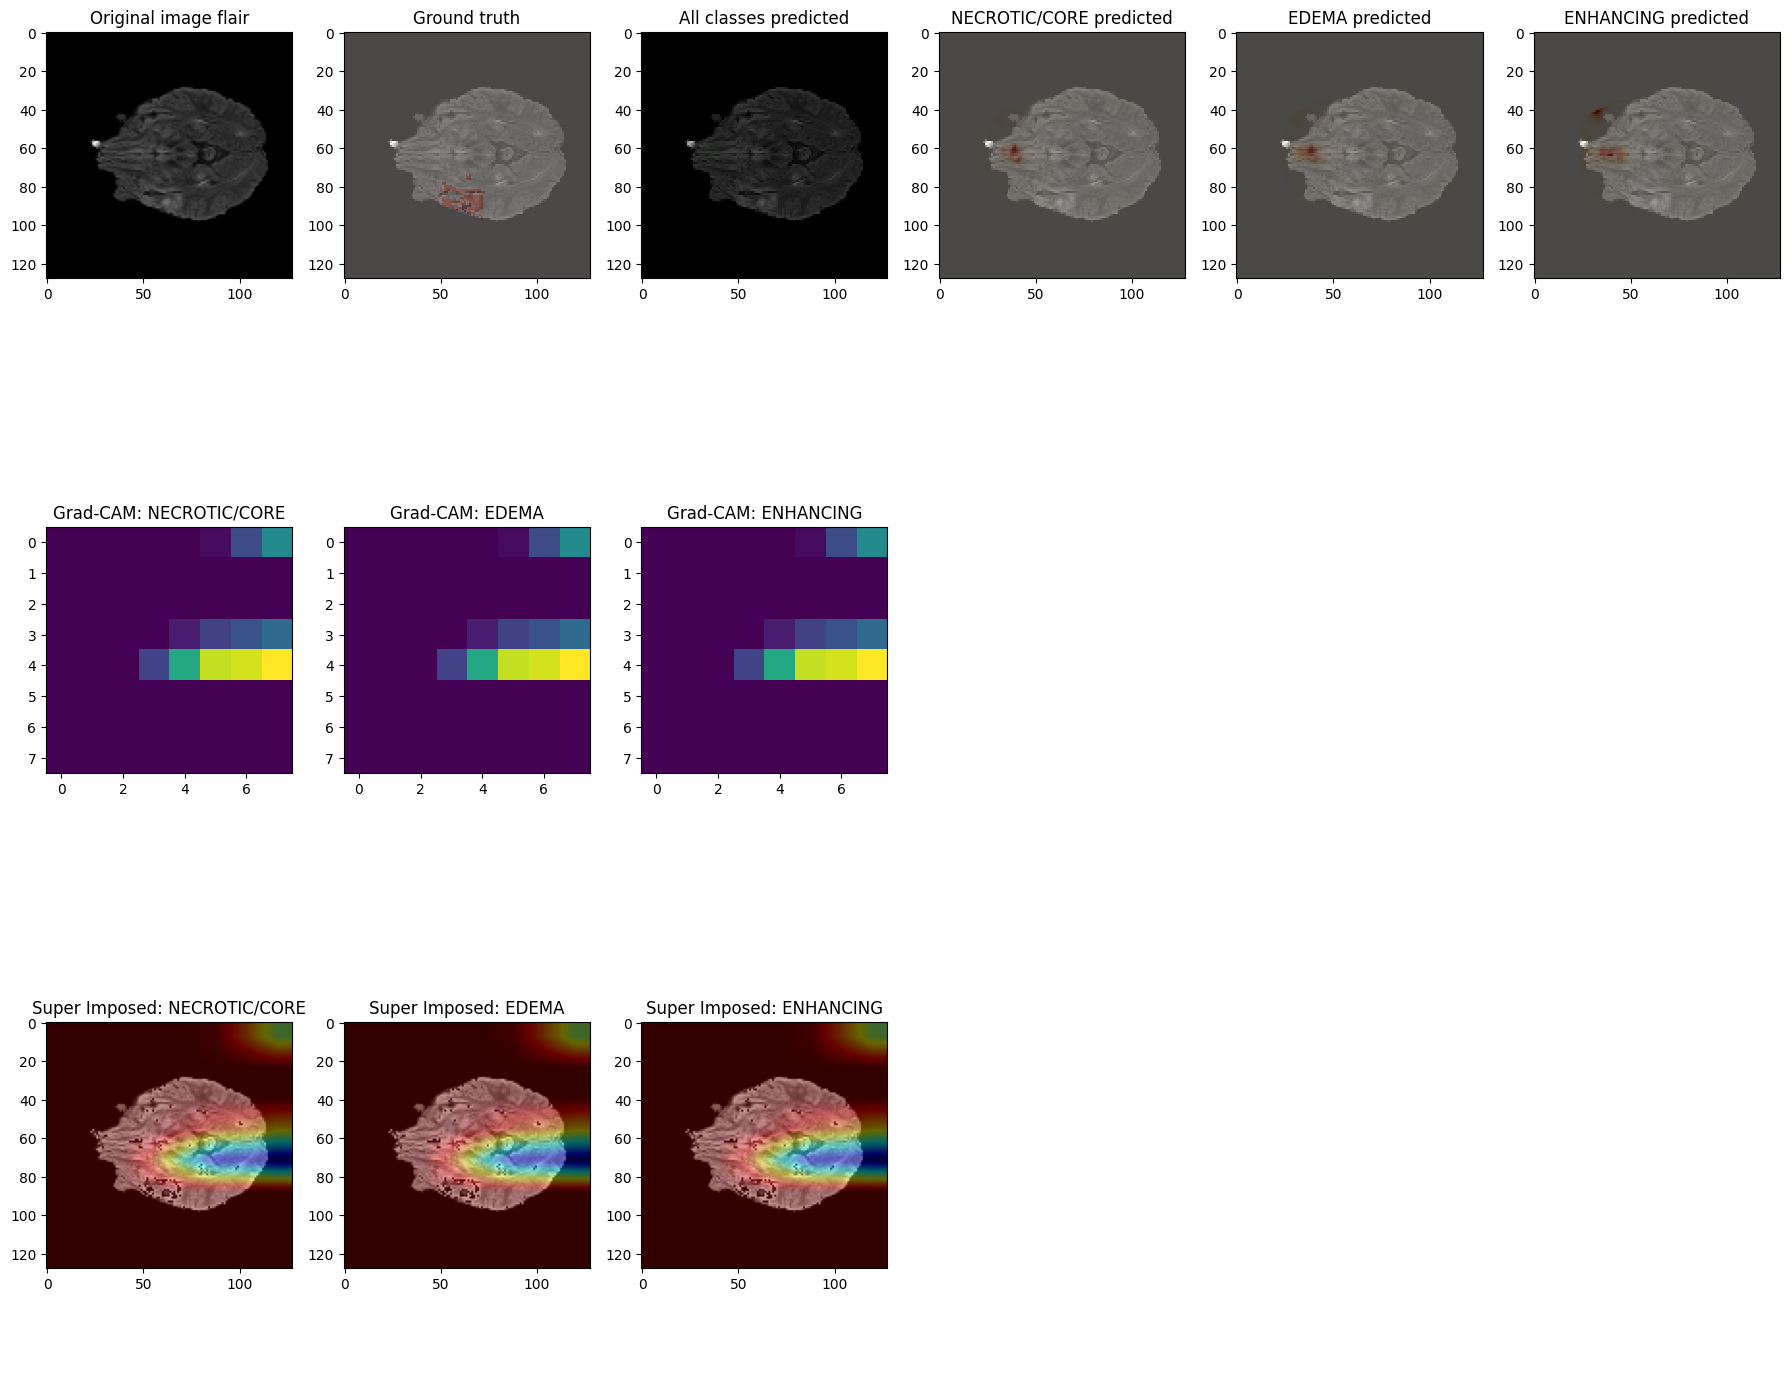

In [ ]:
showPredictsById(case=test_ids[2][-3:])


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


<Figure size 1800x5000 with 0 Axes>

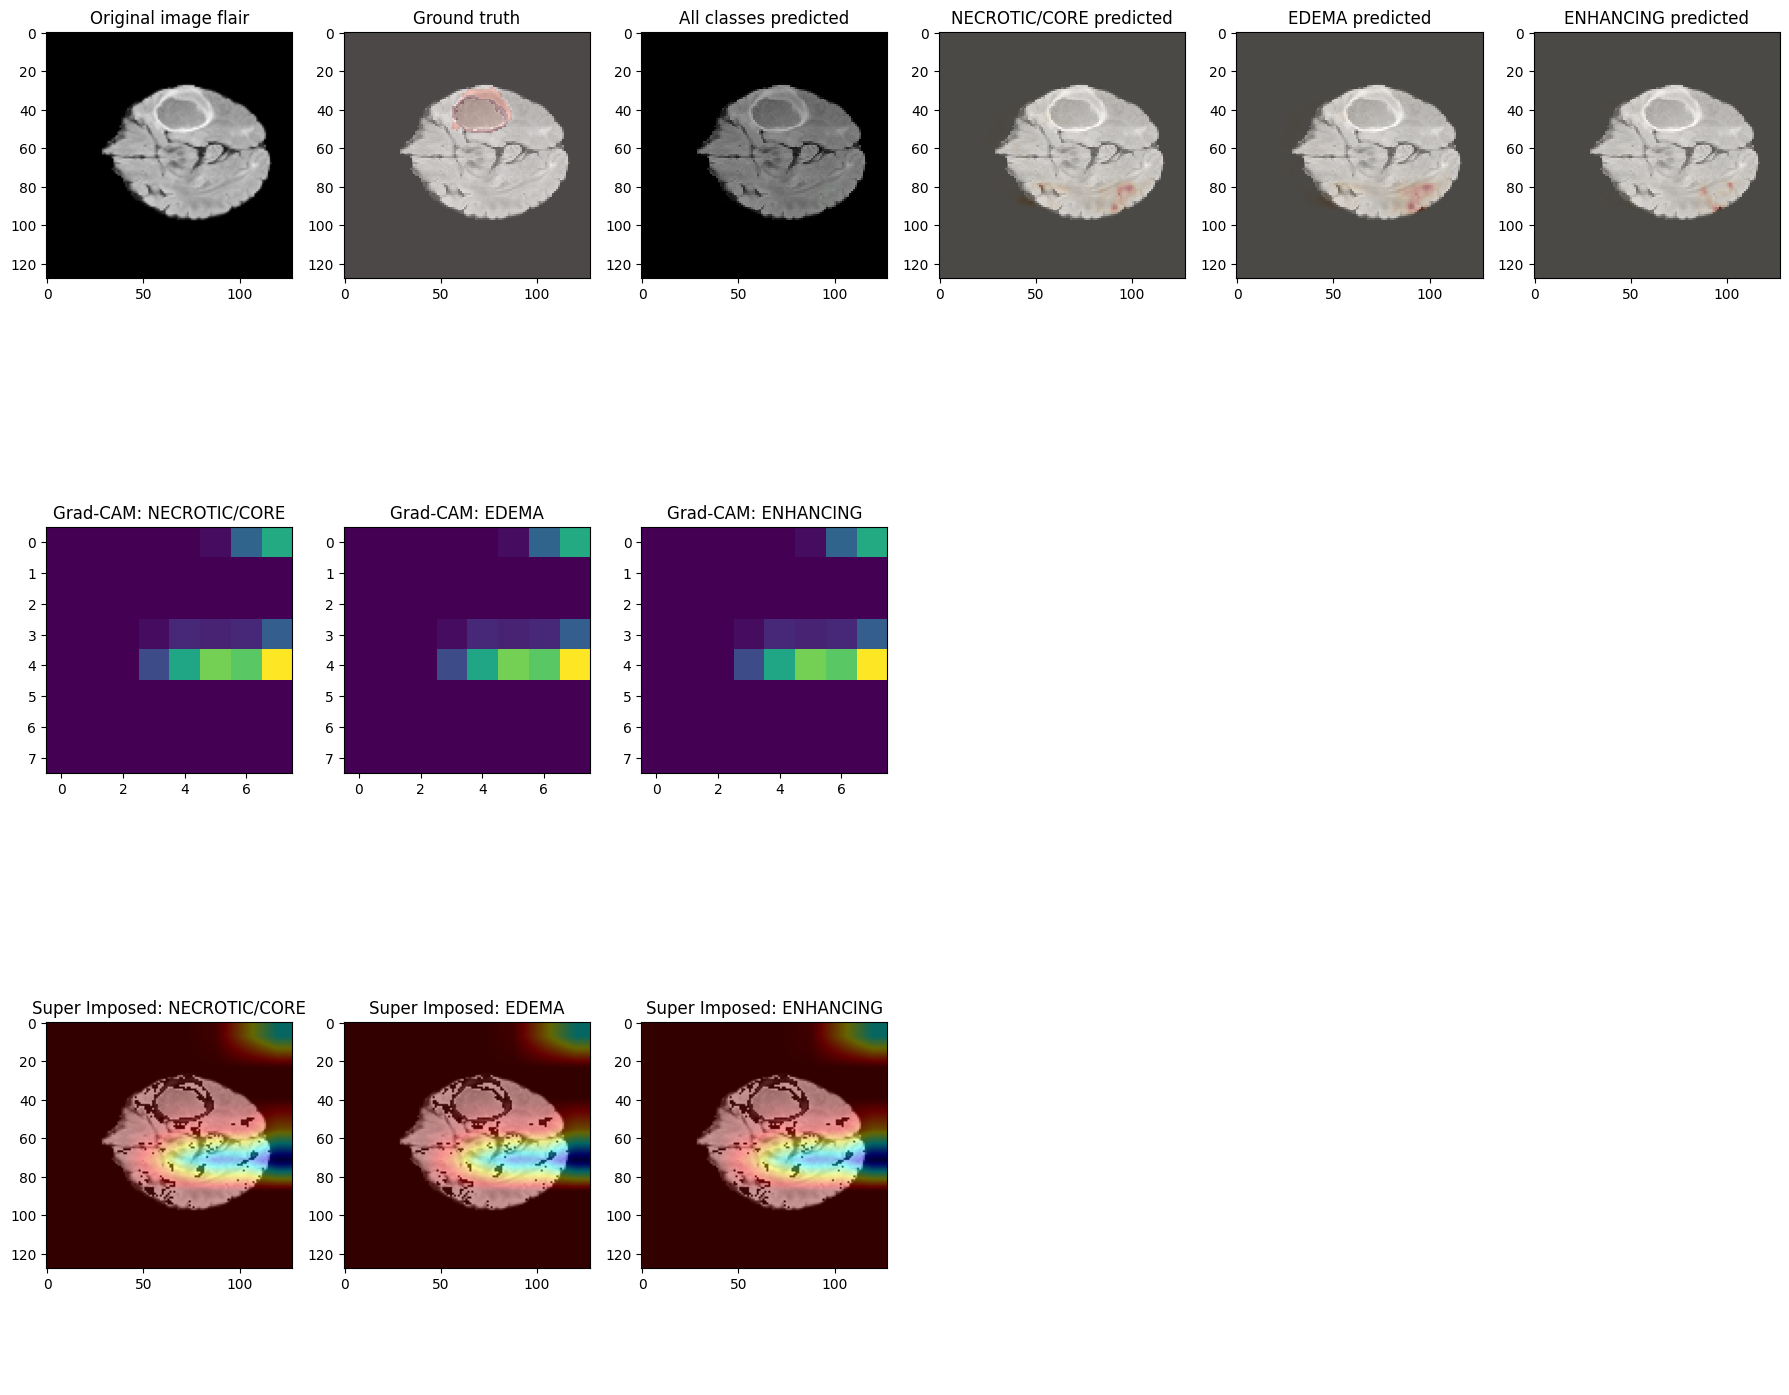

In [ ]:
showPredictsById(case=test_ids[3][-3:])


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


<Figure size 1800x5000 with 0 Axes>

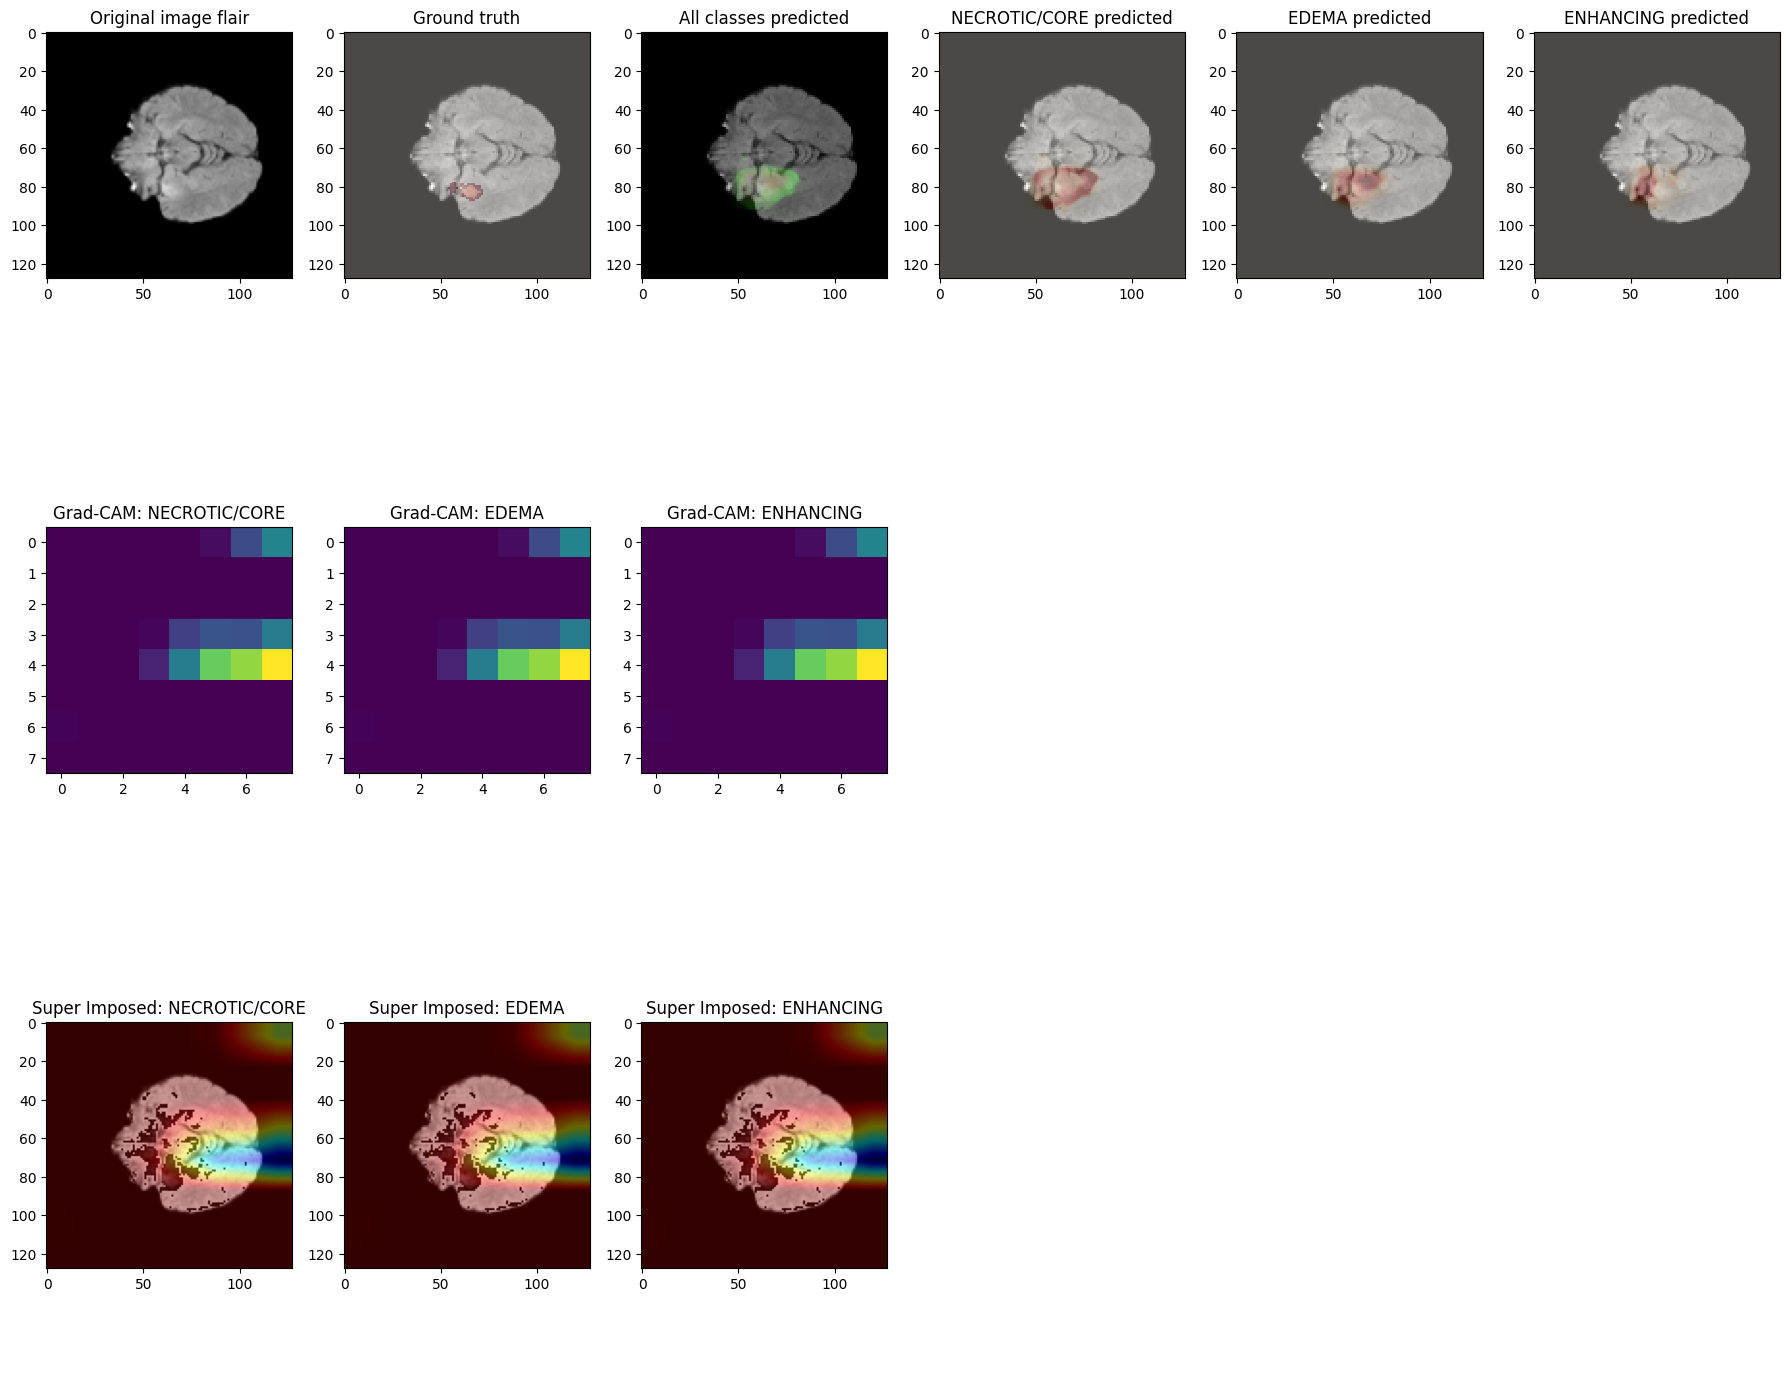

In [ ]:
showPredictsById(case=test_ids[4][-3:])


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


<Figure size 1800x5000 with 0 Axes>

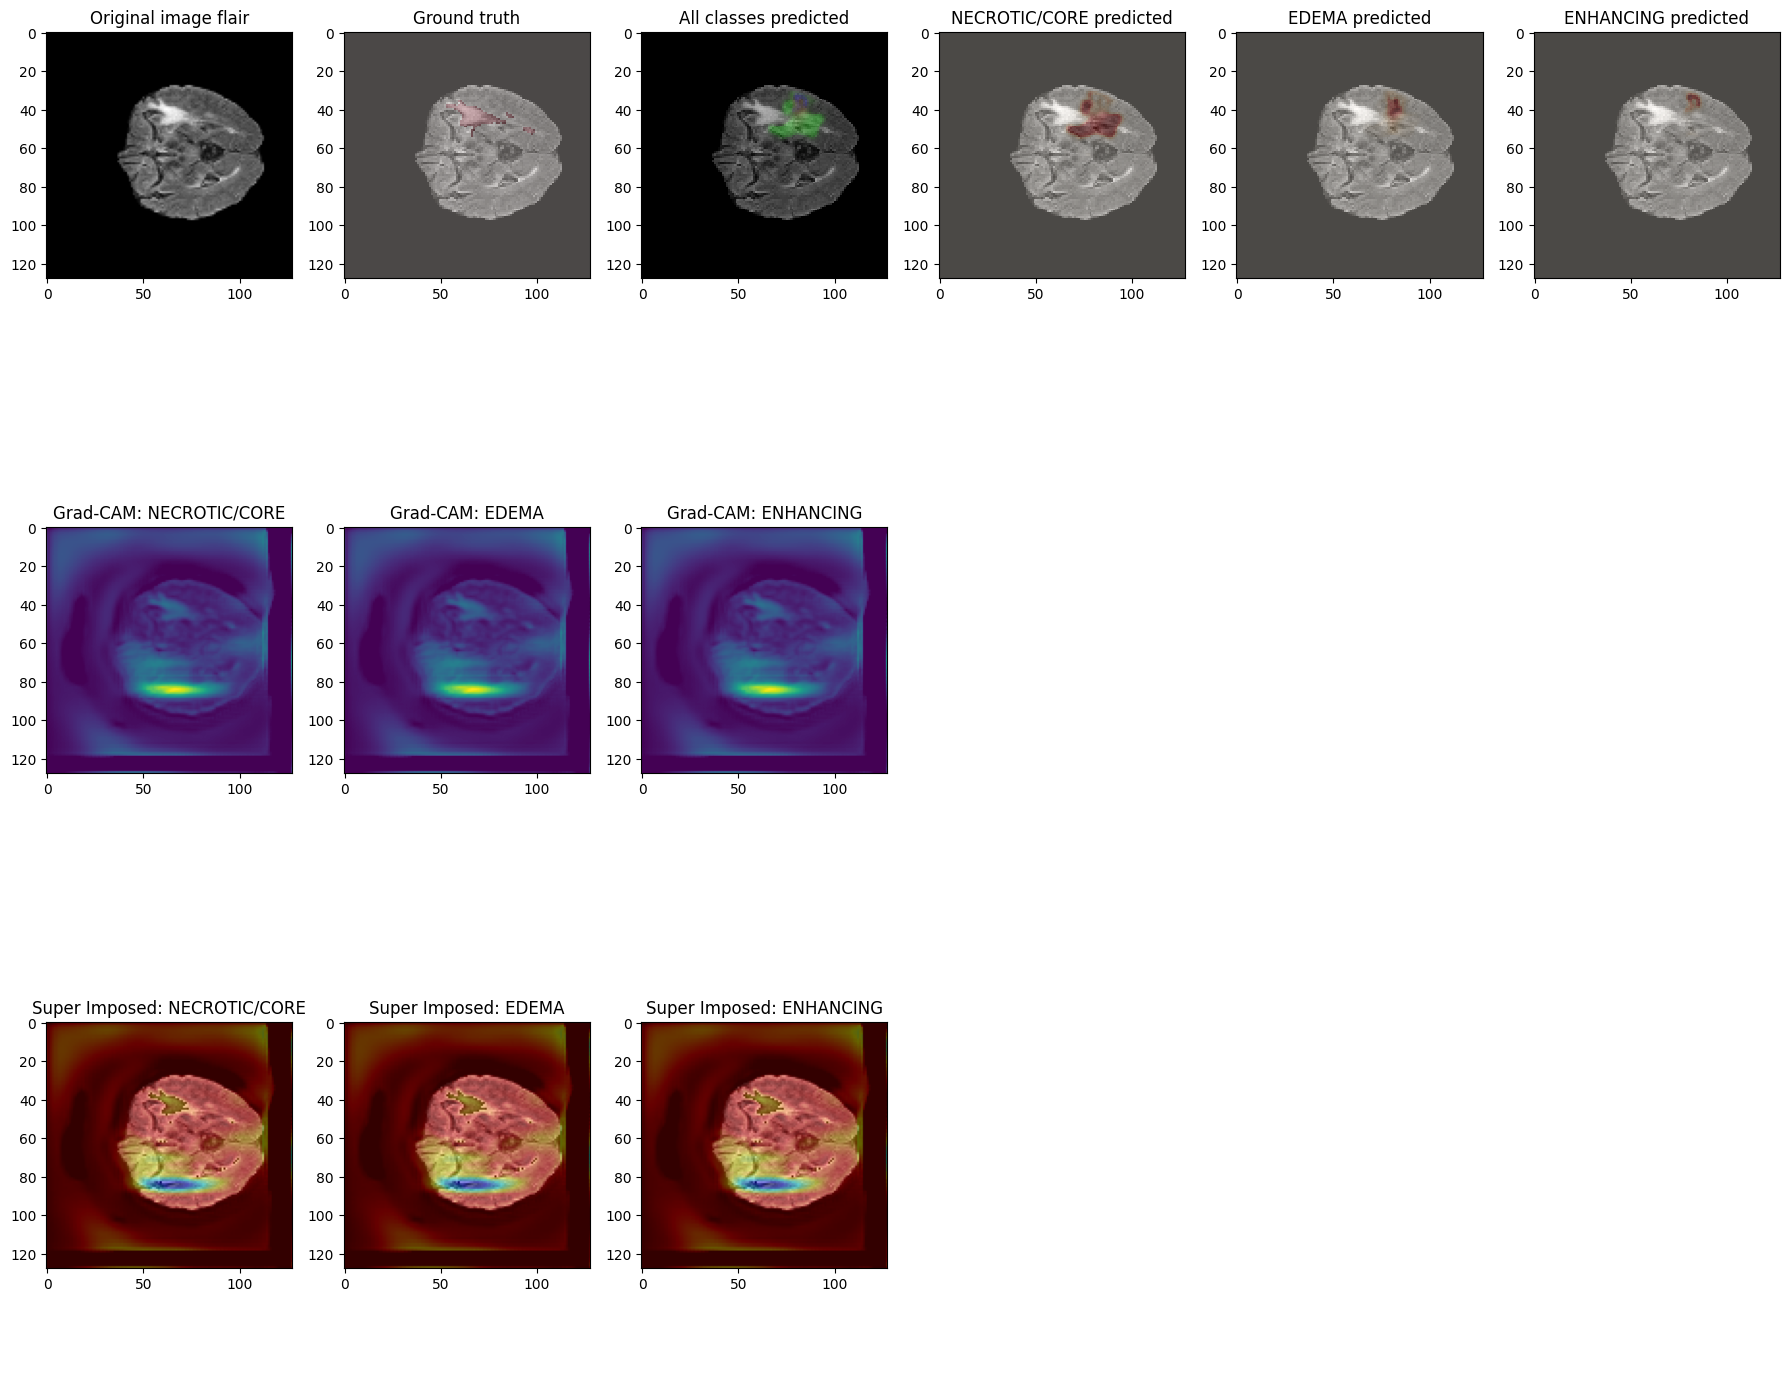

In [ ]:
showPredictsById(case=test_ids[5][-3:])


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


<Figure size 1800x5000 with 0 Axes>

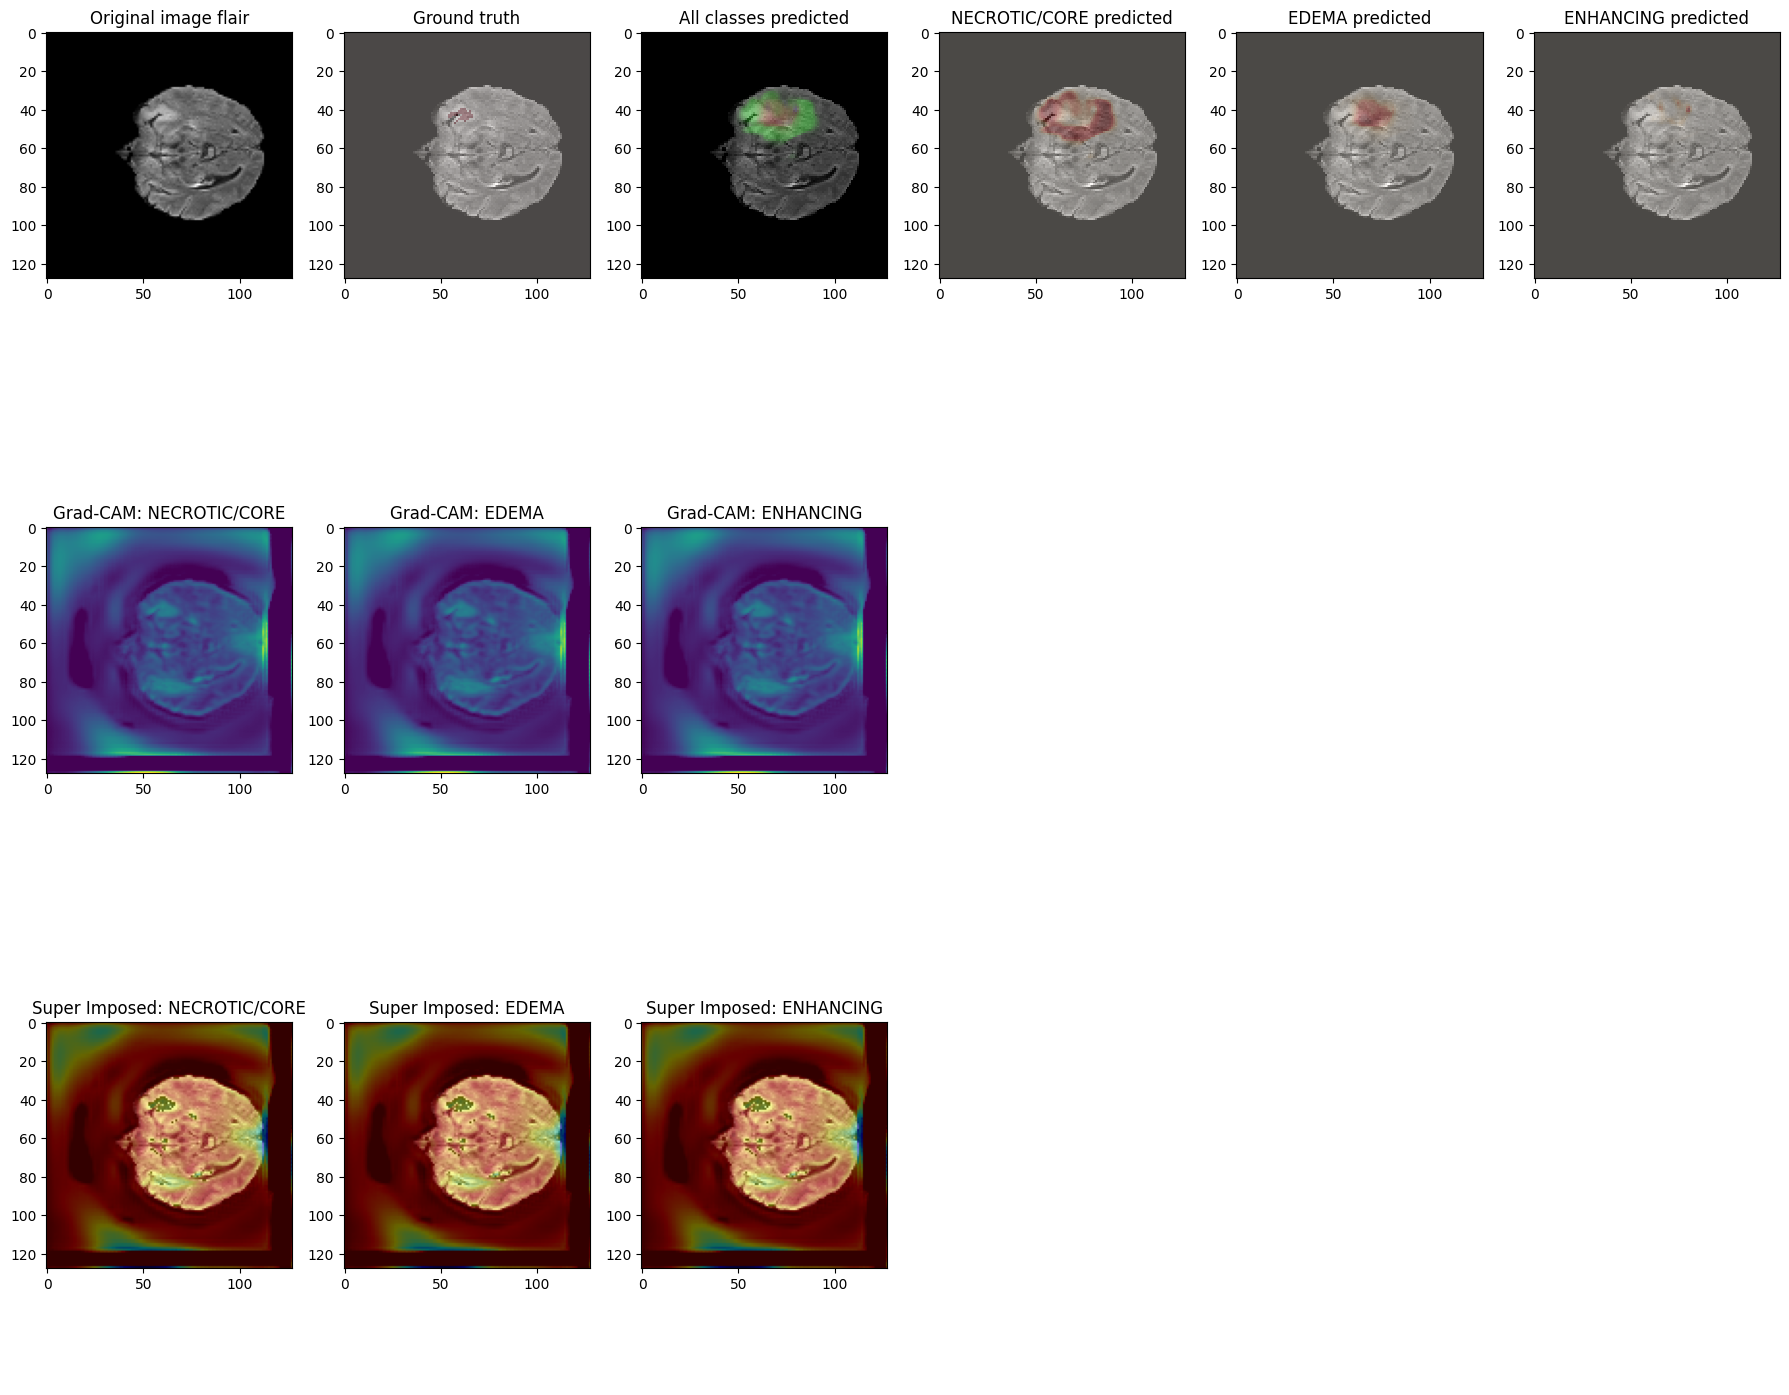

In [ ]:
showPredictsById(case=test_ids[6][-3:])


In [ ]:
def predict_segmentation(sample_path):
    # Load NIfTI (.nii) files of the sample (patient)
    t1ce_path = sample_path + '_t1ce.nii'
    flair_path = sample_path + '_flair.nii'

    # Extract the data from these paths
    t1ce = nib.load(t1ce_path).get_fdata()
    flair = nib.load(flair_path).get_fdata()

    # Create an empty array
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    # Perform the same operations as our DataGenerator, to keep the same input shape
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    # Send our images to the CNN model and return predicted segmentation
    return model.predict(X/np.max(X), verbose=1)

In [ ]:
def show_predicted_segmentations(samples_list, slice_to_plot, cmap, norm):
    # Choose a random patient
    random_sample = random.choice(samples_list)

    # Get path of this patient
    random_sample_path = os.path.join(TRAIN_DATASET_PATH, random_sample, random_sample)

    # Predict patient's segmentation
    predicted_seg = predict_segmentation(random_sample_path)

    # Load patient's original segmentation (Ground truth)
    seg_path = random_sample_path + '_seg.nii'
    seg = nib.load(seg_path).get_fdata()

    # Resize original segmentation to the same dimensions of the predictions. (Add VOLUME_START_AT because original segmentation contains 155 slices vs only 75 for our prediction)
    seg=cv2.resize(seg[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)

    # Differentiate segmentations by their labels
    all = predicted_seg[slice_to_plot,:,:,1:4] # Deletion of class 0 (Keep only Core + Edema + Enhancing classes)
    zero = predicted_seg[slice_to_plot,:,:,0] # Isolation of class 0, Background (kind of useless, it is the opposite of the "all")
    first = predicted_seg[slice_to_plot,:,:,1] # Isolation of class 1, Core
    second = predicted_seg[slice_to_plot,:,:,2] # Isolation of class 2, Edema
    third = predicted_seg[slice_to_plot,:,:,3] # Isolation of class 3, Enhancing

    # Plot Original segmentation & predicted segmentation
    print("Patient number: ", random_sample)
    fig, axstest = plt.subplots(1, 6, figsize=(25, 20))

    # Original segmentation
    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Original Segmentation')

    # Layers 1, 2, 3
    axstest[1].imshow(all, cmap, norm)
    axstest[1].set_title('Predicted Segmentation - all classes')

    # Layer 0
    axstest[2].imshow(zero)
    axstest[2].set_title('Predicted Segmentation - Not Tumor')

    # Layer 1
    axstest[3].imshow(first)
    axstest[3].set_title('Predicted Segmentation - Necrotic/Core')

    # Layer 2
    axstest[4].imshow(second)
    axstest[4].set_title('Predicted Segmentation - Edema')

    # Layer 3
    axstest[5].imshow(third)
    axstest[5].set_title('Predicted Segmentation - Enhancing')

    # Add space between subplots
    plt.subplots_adjust(wspace=0.8)

    plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Patient number:  BraTS20_Training_367


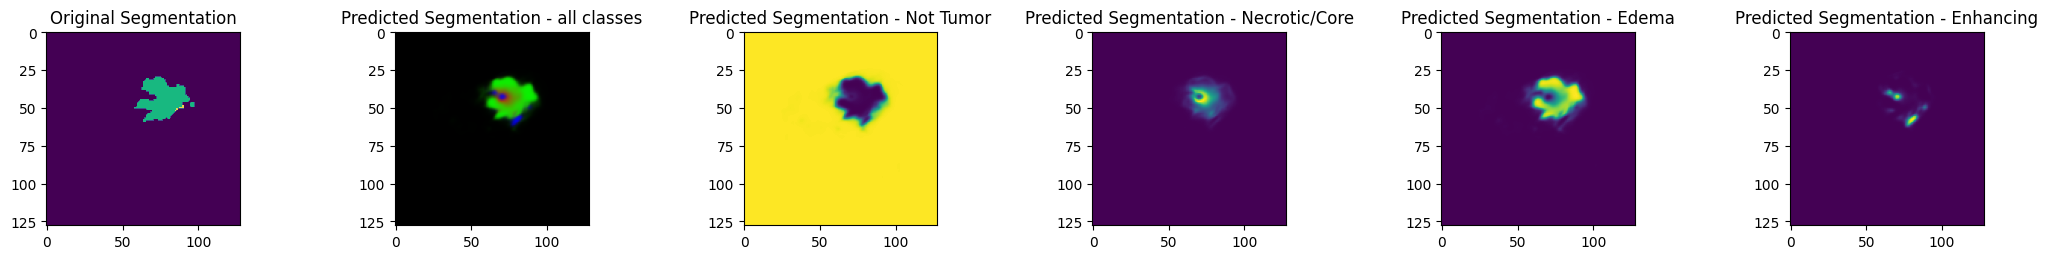

In [ ]:
show_predicted_segmentations(test_ids, 60, cmap, norm)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Patient number:  BraTS20_Training_163


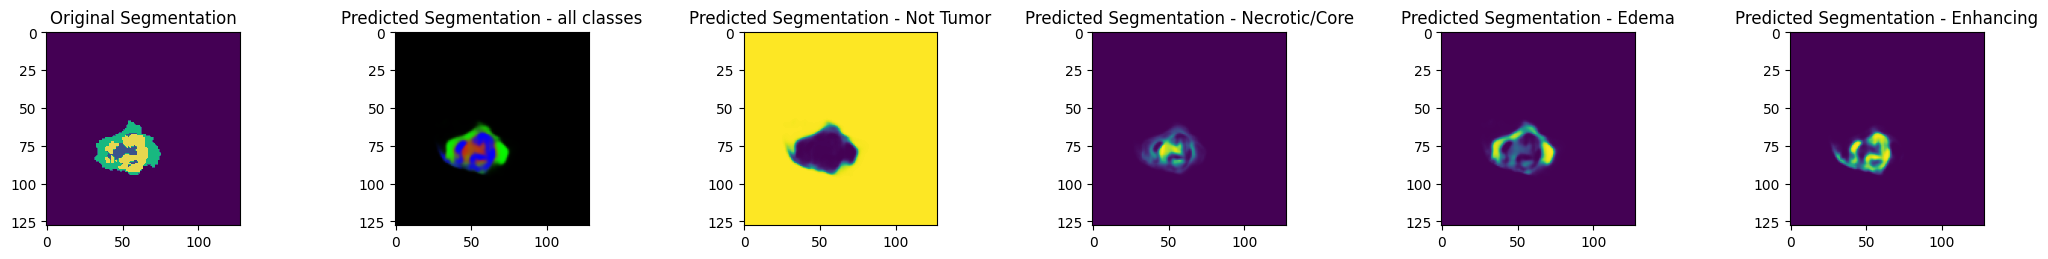

In [ ]:
show_predicted_segmentations(test_ids, 60, cmap, norm)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Patient number:  BraTS20_Training_210


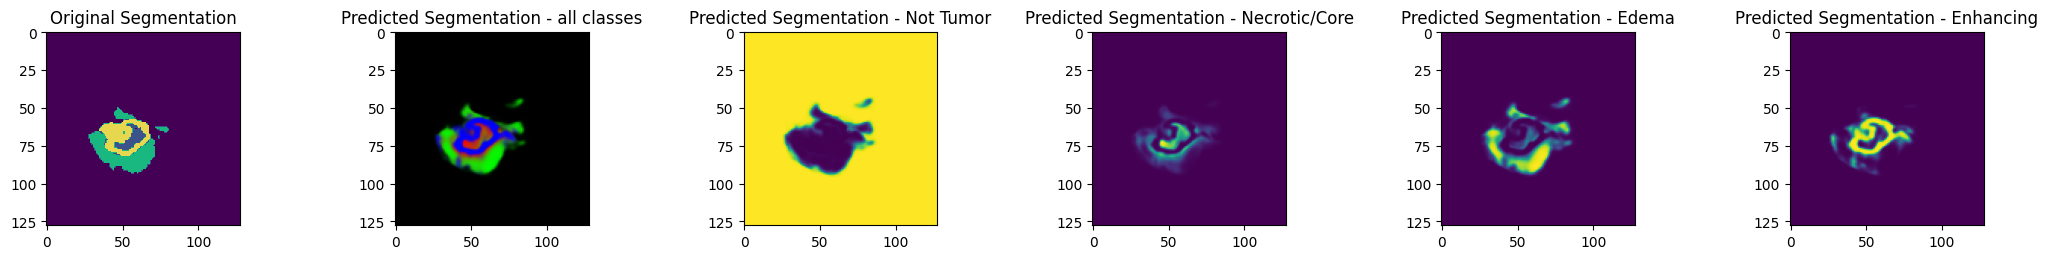

In [ ]:
show_predicted_segmentations(test_ids, 65, cmap, norm)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


<Figure size 640x480 with 0 Axes>

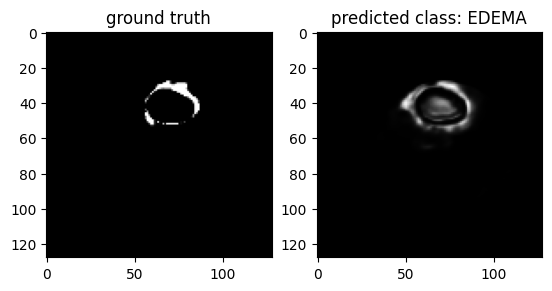

In [ ]:
case = test_ids[3][-3:]
path = f"/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path,case)

core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]

i=40 # slice at
eval_class = 2 #     0 : 'NOT tumor',  1 : 'ENHANCING',    2 : 'CORE',    3 : 'WHOLE'

gt[gt != eval_class] = 1 # use only one class for per class evaluation

resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1,2)
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('ground truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

In [ ]:
# Evaluate the model on the test data
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing])

results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)

descriptions = ["Loss", "Accuracy", "MeanIOU", "Dice coefficient", "Precision", "Sensitivity", "Specificity", "Dice coef Necrotic", "Dice coef Edema", "Dice coef Enhancing"]

# Combine results list and descriptions list
results_list = zip(results, descriptions)

# Display each metric with its description
print("\nModel evaluation on the test set:")
print("==================================")
for i, (metric, description) in enumerate(results_list):
    print(f"{description} : {round(metric, 4)}")

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 393ms/step - accuracy: 0.9918 - dice_coef: 0.5391 - dice_coef_edema: 0.6723 - dice_coef_enhancing: 0.5757 - dice_coef_necrotic: 0.4282 - loss: 0.0237 - mean_io_u_7: 0.5282 - precision: 0.9931 - sensitivity: 0.9898 - specificity: 0.9977

Model evaluation on the test set:
Loss : 0.0235
Accuracy : 0.9915
MeanIOU : 0.5
Dice coefficient : 0.5355
Precision : 0.9931
Sensitivity : 0.9895
Specificity : 0.9977
Dice coef Necrotic : 0.4471
Dice coef Edema : 0.657
Dice coef Enhancing : 0.5626
